In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import os

cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, '..'))
sys.path.append(parent_dir)

import c2qa
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister
from qutip import *
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from scipy.stats.contingency import margins
from qiskit.quantum_info import partial_trace

## Basic States

In [2]:
cutoff = 2**6
qmr1 = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))),name = 'qumode')
qbr = QuantumRegister(1)
cr = ClassicalRegister(1)

circuit = c2qa.CVCircuit(qmr1, qbr, cr)
circuit.cv_initialize(0, qmr1[0])

state, result, _ = c2qa.util.simulate(circuit,shots = 1024)

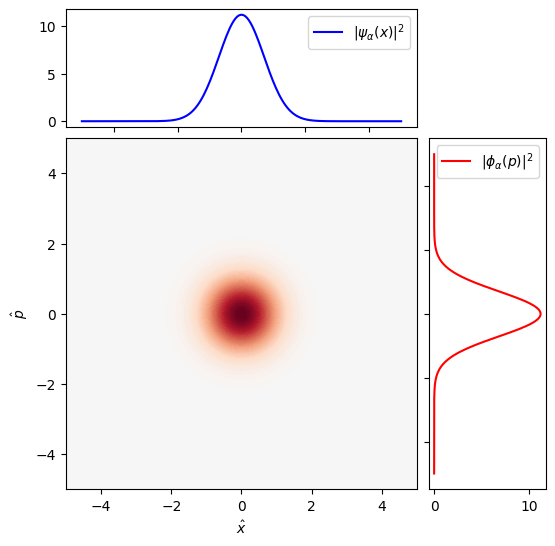

In [3]:
#This cell is mostly plotting
w = c2qa.wigner.wigner(state, axes_max= 5, axes_min= -5, axes_steps = 200)
x_dist, y_dist = margins(w.T)

fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(1, 3),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax_x = fig.add_subplot(gs[0,0])
ax_y = fig.add_subplot(gs[1,1])

absmax = max(np.max(w), np.abs(np.min(w)))
color_levels = np.linspace(-absmax, absmax, 100)

#Plot the wigner function of the vaccum state in the main panel with a colormap
xaxis = np.linspace(-5, 5, 200)
yaxis = np.linspace(-5, 5, 200)
cont = ax.contourf(xaxis, yaxis, w, color_levels, cmap = "RdBu_r")

#plot the distributions against the (normalized) marginals of the wigner function
ax_x.plot(xaxis, x_dist,  label = r"$|\psi_\alpha(x)|^2$", c= "b")

ax_y.plot(y_dist.T, yaxis, label = r"$|\phi_\alpha(p)|^2$", c = "r")

ax.set(xlabel=r"$\hat x$", ylabel=r"$\hat p$")
ax_x.legend()
ax_y.legend()
ax_x.set_xticklabels([]);
ax_y.set_yticklabels([]);

## Non Deterministic CAT State
Ancilla 0 :- Even Cat State

Ancilla 1 :- Odd Cat State


To differentiate between even and odd cat state , notice the fringes. The centermost fringe for even cat state will be psoitive and it will be negative for odd cat state.

In [6]:
Nmodes=1
Nqubits = 1 
cutoff = 2**6
alpha = 4

qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))),name='qumode')
qbr = QuantumRegister(Nqubits,name='qubit')
cbr = ClassicalRegister(Nqubits)
circuit = c2qa.CVCircuit(qmr, qbr,cbr)

circuit.h(qbr[0])
circuit.cv_c_d(alpha / np.sqrt(2),qmr[0],qbr[0])
circuit.h(qbr[0])

circuit.measure(qbr,cbr)

stateop, result, _ = c2qa.util.simulate(circuit,shots = 1)  # run for only one shot to check the ancilla measurement and wigner function

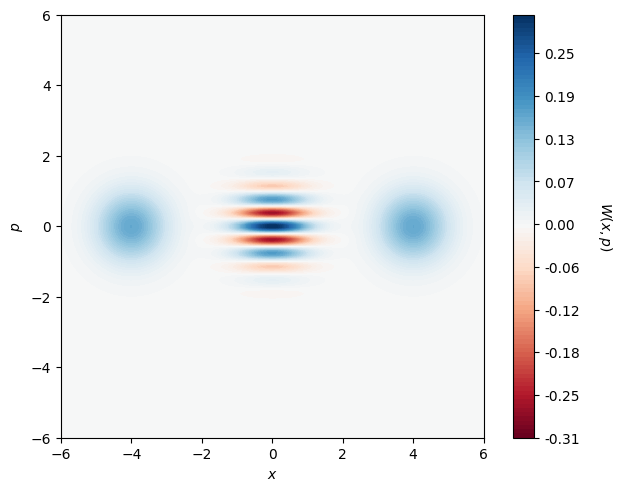

In [7]:
# Plot the wigner function
fig = c2qa.wigner.plot_wigner(circuit, stateop)

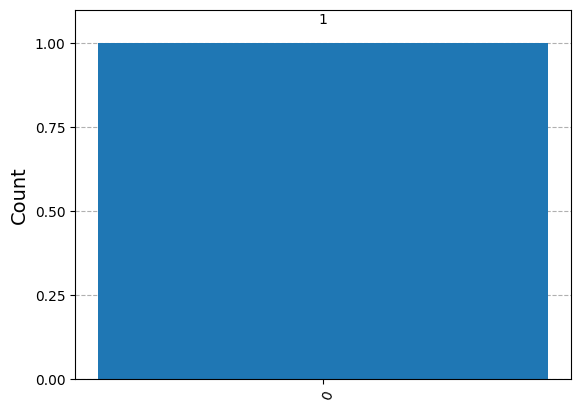

In [8]:
# Find out what was measured in ancilla
# ancilla will be at 0 for even cat state and 1 for odd cat state
plot_histogram(result.get_counts())

## Deterministic  EVEN CAT STATE

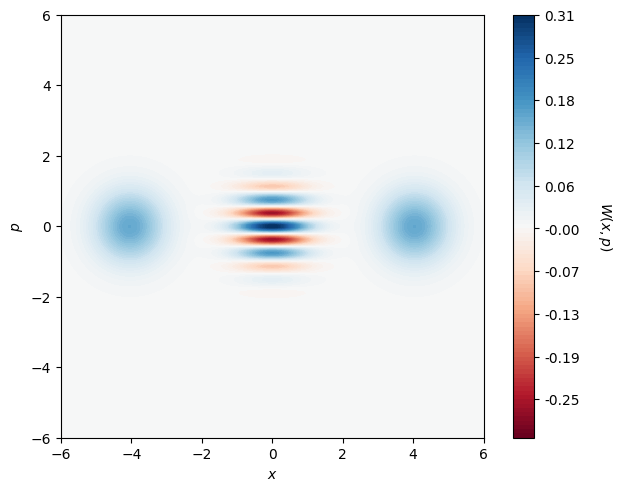

In [2]:
Nmodes=1
Nqubits = 1 
cutoff = 2**6
alpha = 4

qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))),name='qumode')
qbr = QuantumRegister(Nqubits,name='qubit')
cbr = ClassicalRegister(Nqubits)
circuit = c2qa.CVCircuit(qmr, qbr,cbr)

circuit.h(qbr[0])
circuit.cv_c_d(alpha / np.sqrt(2),qmr[0],qbr[0])
circuit.h(qbr[0])

circuit.sdg(qbr[0])
circuit.h(qbr[0])
circuit.cv_c_d(1j*np.pi/(8*alpha*np.sqrt(2)),qmr[0],qbr[0])
circuit.h(qbr[0])
circuit.s(qbr[0])

circuit.measure(qbr,cbr)

stateop, result, _ = c2qa.util.simulate(circuit,shots = 1024)

fig = c2qa.wigner.plot_wigner(circuit, stateop)

## GKP STATE

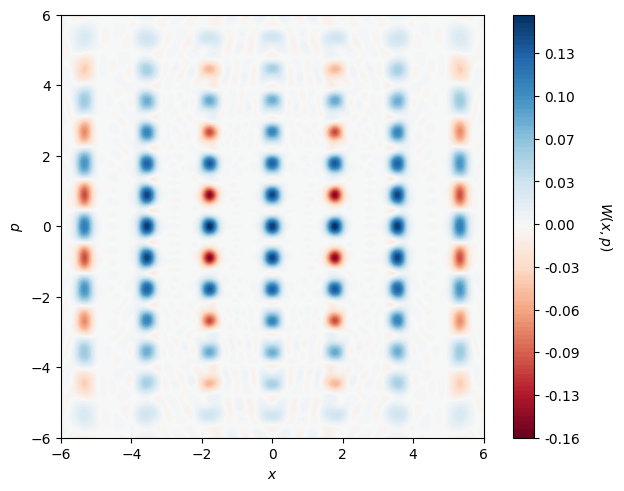

In [6]:
Nmodes=1
Nqubits = 1 
cutoff = 2**6
alpha = np.sqrt(np.pi)
theta = np.sqrt(np.pi)
delta = 0.222
N_rounds = 9
r = -np.log(delta) 


qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=int(np.ceil(np.log2(cutoff))))
qbr = QuantumRegister(Nqubits)
cbr = ClassicalRegister(Nqubits)
circuit = c2qa.CVCircuit(qmr, qbr,cbr)
circuit.cv_sq(r,qmr[0])

for k in range(1,N_rounds):
    circuit.h(qbr[0])
    circuit.cv_c_d(alpha / np.sqrt(2),qmr[0],qbr[0])
    circuit.h(qbr[0])

    circuit.sdg(qbr[0])
    circuit.h(qbr[0])
    circuit.cv_c_d(1j*np.pi/(8*alpha*np.sqrt(2)),qmr[0],qbr[0])
    circuit.h(qbr[0])
    circuit.s(qbr[0])
    
stateop, result, _ = c2qa.util.simulate(circuit,shots = 1024)

fig = c2qa.wigner.plot_wigner(circuit, stateop)